In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile, io
import cv2 as cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy.signal import find_peaks
from scipy.stats import pearsonr
from tqdm import tqdm
from imutils import build_montages
import random
import math

# Creating Signals from csv files
- first data is unziped from archive
- second each file is being iterrated over
- third each column in a single file is choped into separate signals
- fourth all signals are combined in a single signals list

In [1]:
def chop_signal(signal, randomize, seed, distance, prominence, noisiness,  height):
  """Function for chopping time series into signals based on the peaks found

  Args:
      signal (pd series): signal to chop, index represents time in ms while values are voltage in mv
      randomize (boolean): parameter controling randomization
      seed (int): seed for reproducability
      distance (int): amount of miliseconds to add/ subtract from position of any peak found
      prominence (float): percentage to apply to max height for prominence factor
      noisiness (int): max number of peaks, if more peaks are found signal is discarded
      height (int): minimjum height of a peak recquired

  Returns:
      list: list of signals chopped for channel given
  """
  random.seed(seed)
  
  # magnifying peaks
  squared_signal = signal**2 
  # calculating the prominence (prom) by taking prominence % of the highest peak found
  prom = prominence * np.max(squared_signal) 
  # Executing scipy function
  peaks = find_peaks(squared_signal, distance=distance, prominence=prom, height=height)
  # list of peak positions
  peaks_pos = peaks[0] 
  
  # data cleaning of all peaks found
  max = len(signal)
  signals = []
  if len(peaks_pos )<noisiness: # omit noisy signals
    # iterrating over all identified valid peaks
    for peak in  peaks_pos :
        # determining distance to wear of from peak
        distance = random.randint(50,100) if randomize else distance
        if peak >=distance and peak <= max-distance:
            chop_signal = pd.DataFrame(signal[peak-distance:peak+distance])
            signals.append(chop_signal)
  return signals

In [ ]:
def get_signals(df,  distance, noisiness, prominence, height, seed, randomize = False):
  """Function for extracting signals columnwise

  Args:
      df (pd dataframe): dataframe of current ECG file
      distance (int): amount of miliseconds to add/ subtract from position of any peak found
      prominence (float): percentage to apply to max height for prominence factor
      noisiness (int): max number of peaks, if more peaks are found signal is discarded
      height (int): minimjum height of a peak recquired
      seed (int): seed for reproducability
      randomize (boolean, optional): parameter controling randomization. Defaults to False

  Returns:
      list: list of extracted signals for the file given
  """
  signals = []
  channels = df.columns
  for channel in channels:
    egm = df[channel]
    new_signals = chop_signal(signal = egm, distance = distance, seed=seed, randomize=randomize, noisiness=noisiness, prominence=prominence, height=height)
    signals.extend(new_signals)
  return signals

In [ ]:
def zip2signals(z, distance, noisiness, prominence, amount, height, seed, randomize):
  """ Function for extracting signals from zip file

  Args:
      z (zipfile): processed zipfile
      distance (int): amount of miliseconds to add/ subtract from position of any peak found
      noisiness (int): max number of peaks, if more peaks are found signal is discarded
      prominence (float): percentage to apply to max height for prominence factor
      amount (int): thresholding param if less signals should be extracted
      height (int): minimjum height of a peak recquired
      seed (int): seed for reproducability
      randomize (boolean): parameter controling randomization

  Returns:
      list: list containing signals processed for zipfile given
  """
  signals = []
  for filename in tqdm(z.namelist(), desc='Extracting signals from Zip...'):
    df = pd.read_csv(z.open(filename), delim_whitespace=True, skiprows=(0,1,2),header=(0))
    new_signals = get_signals(df=df, distance=distance, noisiness=noisiness, prominence=prominence, seed=seed, randomize=randomize, height=height)
    signals.extend(new_signals)
    if  amount!=None and len(signals) > amount:
        break
  print(f"Number of signals extracted: {len(signals[:amount])}")
  return signals[:amount]

In [ ]:
def load_signals(zip_folder, distance, noisiness, prominence, height ,randomize, seed, amount=None):
  """Function for loading data from zip file and converting it to a list with signals
  Args:
      zip_folder (string): path of zip file
      distance (int): amount of miliseconds to add/ subtract from position of any peak found
      noisiness (int): max number of peaks, if more peaks are found signal is discarded
      prominence (float): percentage to apply to max height for prominence factor
      height (int): minimjum height of a peak recquired
      randomize (boolean): parameter controling randomization
      seed (int): seed for reproducability
      amount (int, optional): number of signals after which to stop iteration. If None all files are processed. Defaults to None.

  Returns:
      list: list of signals
  """
  z = zipfile.ZipFile(zip_folder)
  signals = zip2signals(z, amount=amount, distance=distance, noisiness=noisiness, prominence=prominence, randomize=randomize, seed=seed, height=height)
  
  return signals

In [10]:
signals = np.array(load_signals(zip_folder="SourceData.zip", distance=70, noisiness = 17, prominence=0.2, height=10, randomize=False, seed=42))

Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  6.99it/s]

Number of signals extracted: 8071


# Reducing amplitude variation via percentiles

In [11]:
def reduce_percentile(signals, show, threshold):
    """Function for reducing number of signals by looking at amplitude distribution via boxplot

    Args:
        signals (list): signals to reduce
        show (boolean): parameter for displaying boxplot
        threshold (int): 0 represents box, 1 represents whiskers

    Returns:
        list: reduced signal list
    """
    box = plt.boxplot(signals.max(axis=1) - signals.min(axis=1))
    upperbound = [item.get_ydata() for item in box['whiskers']][1][threshold]
    lowerbound = [item.get_ydata() for item in box['whiskers']][0][threshold]
    
    signals_amp = signals.max(axis=1) - signals.min(axis=1)
    signals_amp = signals_amp.flatten()
    signals = signals[((signals_amp > lowerbound) & (signals_amp < upperbound)).nonzero()[0]]
    if show :
        plt.ylabel("Signal Amplitude")
        plt.xlabel("Signals")
        plt.tick_params( axis='x', which='both', labelbottom=False)
        plt.title("Amplitude distribution of signals")
        plt.show() 
    else:
        plt.close()
    return signals

## Reducing to inner box

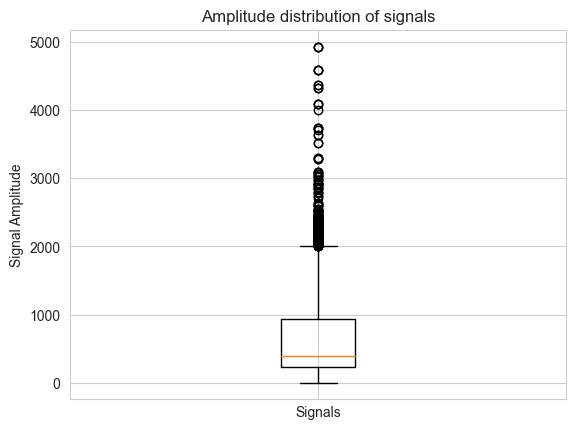

In [12]:
sns.set_style("whitegrid")
signals = reduce_percentile(signals=signals, show=True, threshold=0)[:,:,0]

## Reducing to outer whiskers

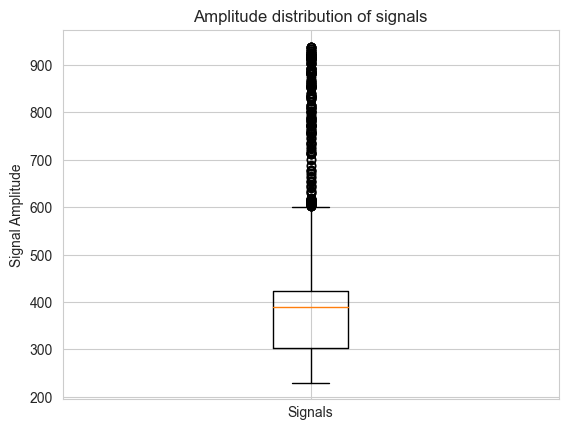

In [13]:
signals = reduce_percentile(signals=signals, show=True, threshold=1)

## Final boxplot

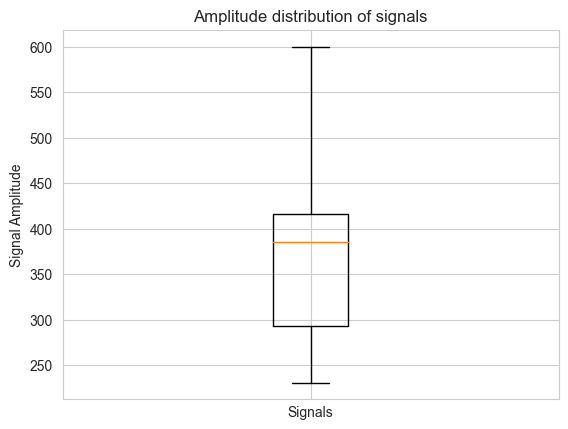

(3729, 140)


In [14]:
res = reduce_percentile(signals=signals, show=True, threshold=1)
print(signals.shape)
plt.show()

# Generating images from signals

In [ ]:
def signal2image(signal, i, size,  imgfolder, ymin, ymax, scalefactor = None ):
    """Function for plotting signal as lineplot and saving the corresponding figure

    Args:
        signal (list): signal for plotting
        i (int): index to add to saved file
        size (int, int): resulting size of the image
        imgfolder (string): url to folder location
        ymin (int): minimal y value, used for scaling 
        ymax (int): maximal y value, used for scaling 
        scalefactor (float, optional): percentage value usef for randomized scaling . Defaults to None.
    """

    y = signal
    x = np.arange(len(signal))
 
    # Draw signal on dark background
    sns.set_style("darkgrid")
    sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
    fig, ax = plt.subplots(1, figsize=(size[0] / 100, size[1] / 100)) # skalierung gemäß den verhältnissen meines monitors, dpi zahl etc

    ax.set_ylim(ymin * scalefactor, ymax * scalefactor)
    sns.lineplot(y=y, x=x, color="white", ax=ax)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(x=0)
    plt.savefig(f"{imgfolder}/img{i}.png", facecolor=fig.get_facecolor(), dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()
    

In [ ]:
def generate_images(signals, size, imgfolder, ymin, ymax, scalefactor):
  """Function for plotting all signals and saving them as images

  Args:
        signals (list): signals for plotting
        size (int, int): resulting size of the image
        imgfolder (string): url to folder location
        ymin (int): minimal y value, used for scaling 
        ymax (int): maximal y value, used for scaling 
        scalefactor (float, optional): percentage value usef for randomized scaling . Defaults to None.
  """
  i = 0
  for signal in tqdm(signals, desc='Generating images of signals...'):
    signal2image(signal, size=size, i=i,  imgfolder=imgfolder, ymin=ymin, ymax=ymax, scalefactor=scalefactor)
    i += 1


In [15]:
border = 36.1
# experimental margin to ensure equal size as defined since shape is lost due to omitting padding and tight layout
generate_images(signals, size=(224 + border + 0.5,224 + border), imgfolder="trainingimgs", ymin=signals.min(), ymax=signals.max(), scalefactor = 1.5 )

Generating images of signals...: 100%|██████████| 3729/3729 [03:09<00:00, 19.65it/s]


# Computing correlation labels

In [ ]:
def compute_ncc(a, b, corr="Pearson"):
  """Function for computing correlation between two series

  Args:
      a (array): first series
      b (array): second series
      corr (str, optional): correlation function to use. Defaults to "Pearson".

  Returns:
      np array: calculated correlation value
  """
  if a.shape != b.shape:
    print('Error: signals are of different lenght!')
    return float('NaN')
  elif corr == "Pearson":
    c = pearsonr(a, b) 
    score = c[0]
  return np.round(score,2)

In [ ]:
def make_labels(signals, corr, n_templates = None):
    """Function for calculating labels for all signals passed

    Args:
        signals (list): list of signals
        corr (string): correlation function to use
        n_templates (int, optional): Threshold number of templates for reduction. Defaults to None, than all signals are used

    Returns:
        (np array, np array): touple containing two arrays, the first keeping the indexes of images, the second the calculated label for this image pair
    """
    # initialize two empty lists to hold the indexes of (image, image) pairs and
    # labels to indicate the match score

    pairImages = []
    pairLabels = []
    number = len(signals)
    if n_templates == None:
      n_templates = len(signals)
      
    # loop over n_templates of images
    for idxA in tqdm(np.random.choice(np.arange(0, number), size=n_templates), desc='Generating pairs and labels ...'):     
        for idxB in np.random.choice(np.arange(0, number), size=number): # loop until uniform distibution
            label = compute_ncc(signals[idxA], signals[idxB], corr=corr) # calculate label       
            pairImages.append([idxA, idxB])
            pairLabels.append(label)

    # return a 2-tuple of image pair indexes and labels
    print('Number of pairs generated: ', len(pairLabels))
    return (np.array(pairImages), np.array(pairLabels))

In [16]:
pairs, labels = make_labels(signals = signals, corr="Pearson")

Generating pairs and labels ...: 100%|██████████| 3729/3729 [05:44<00:00, 10.81it/s]


Number of pairs generated:  13905441


# Taking a look at labels distribution

Text(0.5, 0, 'Correlation Value')

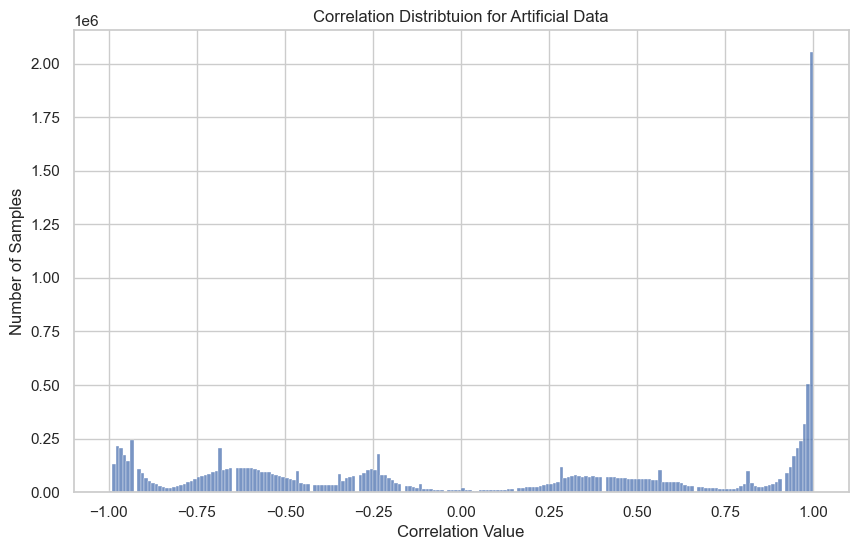

In [17]:
# Distribution of the labels in test set
# Draw signal 
sns.set_style("whitegrid")
fig ,ax = plt.subplots(1,1,figsize=(10,6))
sns.histplot(labels, bins=200, ax=ax )
plt.title("Correlation Distribtuion for Artificial Data")
plt.ylabel("Number of Samples")
plt.xlabel("Correlation Value")

## Applying binning and reducing number of pairs to lowest value for equal class distribution

In [18]:
minsubgroup = 1000
start = -100
stop = 100
threshold =  float('inf')
for i in range(start,stop,1):
    group = i / 100
    subgroup = labels[labels == (group) ]
    if subgroup.size < threshold:
        threshold = subgroup.size 
        minsubgroup = subgroup[0]     
print(f"Smallest subgroup is: {minsubgroup} with threhsold: {threshold}")

Smallest subgroup is: -1.0 with threhsold: 3538


In [19]:
def leveldistribution(labels, pairs, start, stop, threshold =  float('inf')):
    """Function for leveling label distribution according to bin size

    Args:
        labels (np array): labels to use for reduction 
        pairs (np array): array of image pairs with indexes
        start (int): lower bin value
        stop (int): upper bin value
        threshold (int, optional): lower bound to use for bins. Defaults to float('inf')

    Returns:
        list, list: labels, pairs
    """
    for i in range(start,stop,1):
        group = i / 100
        subgroup = labels[labels == (group) ]
        if subgroup.size < threshold:
            threshold = subgroup.size 
    respairs = []
    reslabels = []
    np.random.seed(42)
    for i in range(start,stop,1):
        group = i / 100
        subpairs = pairs[labels == (group) ]
        sublabels = labels[labels == (group) ]
        subids  = np.random.choice(sublabels.size, threshold)
        subpairs = subpairs[subids]
        sublabels = sublabels[subids]
        reslabels.extend(sublabels)
        respairs.extend(subpairs)

    reslabels = np.array(reslabels)
    respairs = np.array(respairs)
    

    return reslabels, respairs

In [20]:
# we omit -1 for threshold search since we deem it as not that important and only very few examples exist 
reslabels, respairs = leveldistribution(labels=labels, pairs=pairs, start=-99, stop=101, threshold=50)

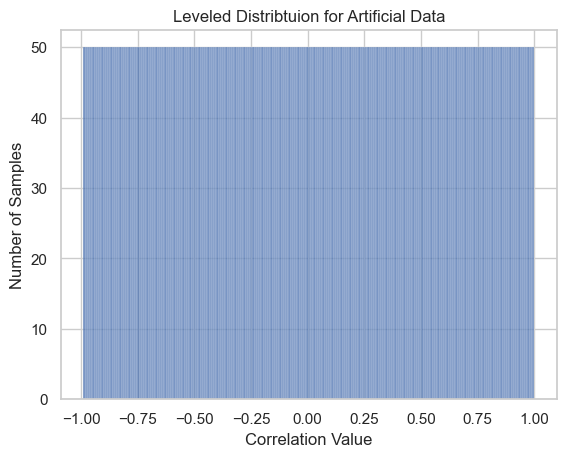

In [21]:
np.unique(reslabels).size, sns.histplot(reslabels,bins=200)
sns.set_style("whitegrid")
plt.title("Leveled Distribtuion for Artificial Data")
plt.ylabel("Number of Samples")
plt.xlabel("Correlation Value")
plt.show()

# Saving final files of pairs, labels and timeseries as numpy arrays

In [22]:
np.save("trainingData/imagePairsPearson", respairs, allow_pickle=True )
np.save("trainingData/imageLabelsPearson", reslabels, allow_pickle=True )
np.save("trainingData/imageLabelstimeseries", signals, allow_pickle=True )

# Repeating the same procedure albeit with randomized data generation

In [23]:
def generate_images(signals, pairs, imgfolder = "trainingimgs_random"):
  """Function for plotting all signals and saving them as images with randomization

  Args:
      signals (list): signals for plotting
      pairs (np array): array of image pairs indexes
      imgfolder (str, optional): folder to use for new plots. Defaults to "trainingimgs_random".

  Returns:
      list, list, list: new image pair indexes, created image plots, logging information which randomiztaion has been applied
  """
  
  realpairs = []
  images = []
  newpairs = []
  logging = []
  i = 0
  # generiere jetzt immer 2 bilder mit gleicher pixel skalierung
  for pair in tqdm(pairs, desc='Generating images of signals...'):
    size = ( random.randint(50,200) + border,  random.randint(50,200) + border)
    scalefactor = random.randint(100,150) / 100
    ymin, ymax = min(signals[pair[0]].min(),signals[pair[1]].min()), max(signals[pair[0]].max(),signals[pair[1]].max())
    image1 = signal2image(signals[pair[0]],  size=size, i=i, imgfolder=imgfolder, scalefactor= scalefactor, ymin=ymin, ymax=ymax )
    image2 = signal2image(signals[pair[1]], size=size, i=i+1, imgfolder=imgfolder, scalefactor= scalefactor, ymin=ymin, ymax=ymax )
    images.append((image1,image2))
    newpairs.append((i,i+1))
    realpairs.append(pairs)
    logging.append((size,scalefactor,ymin,ymax))
    i+=2
  print('Number of images generated: ', len(images))
  return newpairs, images, logging

In [24]:
signals = []
# using several seeds to obtain signals with varying length distribution
for seed in range(0,20):
    signallist = load_signals(zip_folder="SourceData.zip", distance=70, noisiness = 17, prominence=0.2, height=10, randomize=True, seed=seed)
    signals.extend(signallist)

Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.23it/s]


Number of signals extracted: 8063


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


Number of signals extracted: 8098


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


Number of signals extracted: 8097


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


Number of signals extracted: 8096


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.62it/s]


Number of signals extracted: 8095


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.12it/s]


Number of signals extracted: 8047


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.23it/s]


Number of signals extracted: 7993


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


Number of signals extracted: 8071


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.20it/s]


Number of signals extracted: 8097


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.47it/s]


Number of signals extracted: 8059


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.45it/s]


Number of signals extracted: 8054


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


Number of signals extracted: 8059


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.71it/s]


Number of signals extracted: 8058


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.63it/s]


Number of signals extracted: 8094


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.19it/s]


Number of signals extracted: 8096


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.63it/s]


Number of signals extracted: 8097


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.52it/s]


Number of signals extracted: 8063


Extracting signals from Zip...: 100%|██████████| 30/30 [00:04<00:00,  7.04it/s]


Number of signals extracted: 8059


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.57it/s]


Number of signals extracted: 8097


Extracting signals from Zip...: 100%|██████████| 30/30 [00:03<00:00,  7.67it/s]

Number of signals extracted: 8044


# Reducing amplitude distribution and leveling number of different signal lengths obtained 

In [25]:
def reduce_percentile_twice(signals, show):
    """Function for executing amplitude distribution reduction analogues to the uniform case

    Args:
        signals (list): signals generated
        show (boolean): controls display of created boxplots

    Returns:
        : _description_
    """
    signals = reduce_percentile(signals=signals, show=show, threshold=0)
    signals = reduce_percentile(signals=signals, show=show, threshold=1)
    return signals

In [26]:
# alignment of the signals, filtering on all signals that occur at least 100 times in any length (i.e. different signals with a length of 50 are retained if there are more than 100 of them in total).
df_signals = pd.DataFrame({"signal" : signals})
df_signals["length"] = df_signals["signal"].apply(lambda x: len(x))
df_signals["signal"] = df_signals["signal"].apply(lambda x: np.array(x).flatten())
# alignment of all singal lengths by randomly selecting and retaining 50 pieces per length group.
df_signals = df_signals.groupby("length").filter(lambda x: len(x) >= 100)
# applying amplitude reduction by percentiles
df_signals = df_signals.groupby("length")["signal"].apply(lambda x: reduce_percentile_twice(np.array([np.array(a) for a in x]), show=False))
# Creating a list of lists with signals of equal length
df_signals = df_signals.apply(lambda x : x[np.random.randint(0,len(x),100)])
signallist = df_signals.to_list()

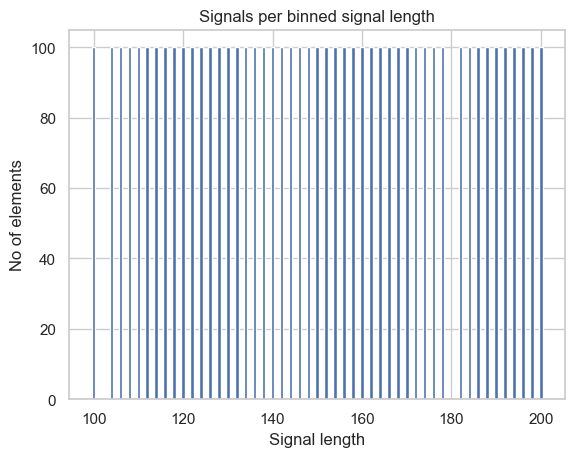

In [27]:
sns.set_style("whitegrid")
plt.bar(df_signals.index,100)
plt.title("Signals per binned signal length")
plt.ylabel("No of elements")
plt.xlabel("Signal length")
plt.show()

# Generating image pairs and calculating correlation labels

In [28]:
pairs = []
labels = []
signals_flat = []
rollingidx = 0
# labels werden nun pro gruppe erzeugt, also pairing zwischen allen signalen der länge 100 etc
for signals in signallist:
    currpairs , currlabels = make_labels(signals = signals , corr="Pearson")
    pairs.extend(currpairs + rollingidx)
    labels.extend(currlabels)
    rollingidx += len(signals )
    signals_flat.extend(signals )

Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 405.44it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 420.02it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 380.79it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 448.19it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 322.94it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 449.05it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 391.87it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 407.29it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 364.03it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 429.69it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 423.35it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 431.68it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 353.33it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 435.83it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 403.19it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 334.97it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 415.80it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 416.82it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 431.91it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 402.99it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 400.51it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 413.76it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 415.44it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 423.79it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 410.72it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 354.70it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 408.71it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 407.48it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 419.25it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 438.45it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 386.81it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 425.58it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 417.60it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 402.99it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 358.91it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 380.68it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 412.11it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 415.13it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 377.25it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 376.43it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 393.49it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 374.60it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 431.54it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 426.78it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 430.61it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 351.46it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 408.07it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 370.62it/s]


Number of pairs generated:  10000


Generating pairs and labels ...: 100%|██████████| 100/100 [00:00<00:00, 419.25it/s]

Number of pairs generated:  10000


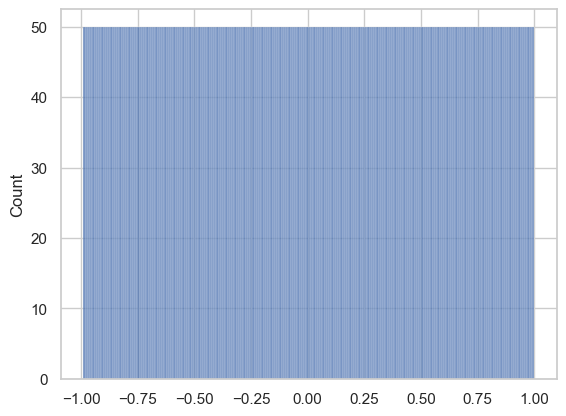

In [29]:
# angleichung der Labels sodass alle korrelationswerte gleich häufig sind
reslabels, respairs = leveldistribution(labels=np.array(labels), pairs=np.array(pairs), start=-99, stop=101, threshold=50)
sns.set_style("whitegrid")
sns.histplot(reslabels, bins=200)
plt.show()

In [30]:
# reindexierung der pairs von 0 bis max sodass immer zwei benachbarte bilder ein paar sind, also 0,1 etc. erzeugung der bilder
newpairs, images, logging = generate_images(signals_flat, respairs, imgfolder = "trainingimgs_random")

Generating images of signals...: 100%|██████████| 10000/10000 [16:55<00:00,  9.85it/s]

Number of images generated:  10000


## Saving the randomized files as numpy arrays

In [31]:
np.save("trainingData/imagePairsRandom", newpairs, allow_pickle=True )
np.save("trainingData/imageLabelsRandom", reslabels, allow_pickle=True )

# Visualizing sample signals

In [2]:
def montage_pairs_samples(pairs, labels, imgloc, size=(7,7)):
    """Function for creating a signal montage

    Args:
        pairs (np array): array containing img indexes
        labels (np array): array containing correlation labels 
        imgloc (string): folder with images corresponding to indexes in pairs array
        size (tuple, optional): size of plotting figure with montages. Defaults to (7,7).

    Returns:
        np array: array containing montages ready for display
    """
    sample = []
    x, y = size
    # loop over a sample of our training pairs
    for i in np.random.choice(np.arange(0, len(pairs)), size=(x * y,)):
    # grab the current image pair and label
        imageA = cv2.cvtColor(cv2.imread(f"{imgloc}/img{pairs[i][0]}.png"),cv2.COLOR_BGR2GRAY)
        imageB = cv2.cvtColor(cv2.imread(f"{imgloc}/img{pairs[i][1]}.png"),cv2.COLOR_BGR2GRAY)
        label = labels[i]

        # to make it easier to visualize the pairs and their positive or
        # negative annotations, we're going to "pad" the pair with 1
        # pixel along borders
        imageA = cv2.copyMakeBorder(imageA,5,5,10,5, borderType = cv2.BORDER_CONSTANT)
        imageB = cv2.copyMakeBorder(imageB,5,5,10,5, borderType = cv2.BORDER_CONSTANT)
        pair = np.hstack([imageA, imageB])
        output = np.ones((pair.shape[0]+20, pair.shape[1]+20), dtype="uint8")
        output[19:-1, 19:-1] = pair
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        # set the text label for the pair along with what color we are
        # going to draw the pair in (green for 'similar signals')
        text = str(label)
        color = (255, 255, 0) #if label < 0.75 else (0, 255, 0)

        cv2.putText(output, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

        # add the pair visualization to our list of output images
        sample.append(output)

    # construct the montage for the images
    montage = build_montages(sample, (pair.shape[1]+20, pair.shape[0]+20), size)[0]
    # show the output montage
    return montage

In [6]:
def cv2_imshow(image):
  """Function for displaying image via cv2 including color conversion

  Args:
      image (list): image to display
      
  """
  # convert the image frame BGR to RGB color space and display it
  plt.figure(figsize=(14, 14))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.grid(False)
  plt.axis('off')
  plt.show()

In [4]:
pairs, labels = np.load("trainingData/imagePairsPearson.npy"), np.load("trainingData/imageLabelsPearson.npy")

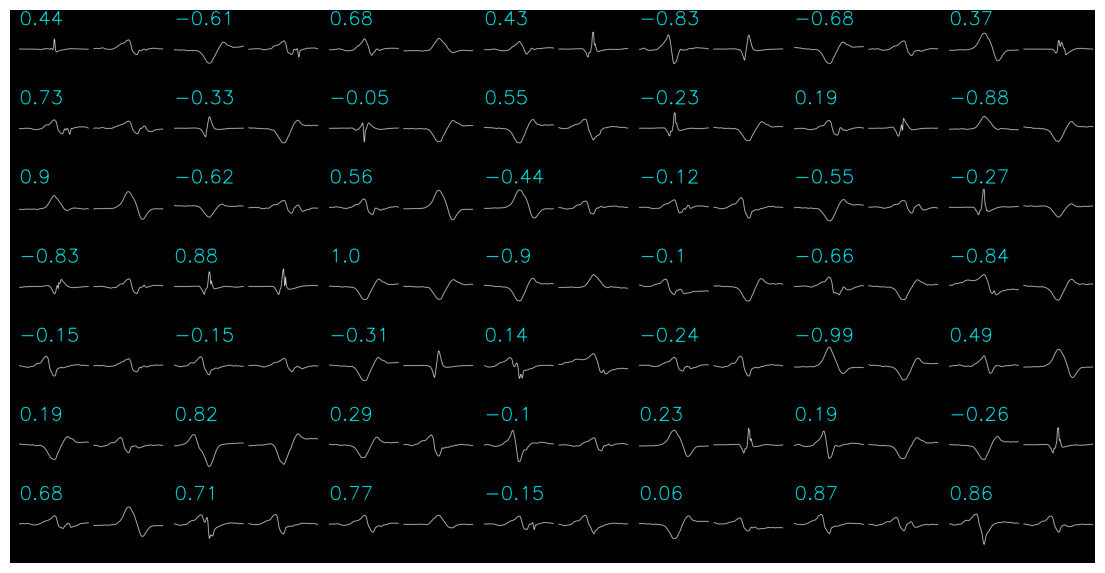

In [7]:
cv2_imshow(montage_pairs_samples(pairs, labels, imgloc="trainingimgs"))